In [ ]:
# Install a conda package in the current Jupyter kernel
import sys
!conda install --yes -c conda-forge wordcloud 

In [1]:
%matplotlib inline
import os
import re
import matplotlib.pyplot as plt
import codecs
import wordcloud

In [2]:
home = os.path.expanduser("~")

In [15]:
bibFile = r"scopus.bib";

In [23]:
content ="";
with codecs.open(bibFile,'r',encoding="utf8") as f:
    content = f.read()

In [24]:
def parseBibtex(stringContent):
    entries = [];
    state = 0;
    key   = "";
    value = "";
    entry = {};
    openBrackets = 0;

    for c in stringContent:
        if state == 0:
            #the beging of a new entry is detected so goes to next state
            if c == '@':
                state = 1;
                entry ={};
                continue;
            elif c in (',', ' ', '\n', '\t'):
                continue;

        elif state == 1:
            #Store entry type until a bracket could be found '{' then goes to next state
            if c == "{":
                entry['type'] = value;
                value ="";
                state = 2;
                continue;
        elif state == 2:
            #Read citation key until comma could be found
            if c == ",":
                entry['citationKey'] = value;
                value = "";
                state = 3;
                continue;
        elif state == 3:
            if c in ("", "="):
                #ignore
                continue;
            elif c == "{":
                #Read all caracteres until an open bracked could be found and store it as attribute key
                key = value.strip();
                value = "";
                state = 4;
                continue;
            elif c == "}":
                #Object end
                state =0;
                entries.append(entry);
                entry = {};
                continue;
            elif c in (',','\n'):
                continue;
        elif state == 4:
            #we are inside a attribute value which could have other '{'.
            #if an open bracket was '{' start counting it and if and close bracket appear decrease the counter.
            #the the counter is zero and an '{' was found than close the atribute value and return to previous state,
            #waiting
            if c == "{":
                openBrackets += 1;
            elif c =="}" and openBrackets !=0:
                openBrackets -= 1;
            elif c =="}" and openBrackets ==0:
                entry[key]=value.strip();
                key ="";
                value ="";
                state = 3;
                continue;
        value = value + c;
    return entries;

In [25]:
entries = parseBibtex(content);

# Análise da bibliografia

In [27]:
import pandas as pd;
import numpy as np;
import math;
from collections import defaultdict;
import matplotlib.pyplot as plt;
%matplotlib inline

In [28]:
df = pd.DataFrame(entries);

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 29 columns):
abbrev_source_title    254 non-null object
abstract               251 non-null object
affiliation            251 non-null object
art_number             52 non-null object
author                 254 non-null object
author_keywords        168 non-null object
citationKey            254 non-null object
coden                  28 non-null object
document_type          254 non-null object
doi                    189 non-null object
editor                 106 non-null object
isbn                   97 non-null object
issn                   206 non-null object
journal                254 non-null object
keywords               196 non-null object
language               254 non-null object
note                   254 non-null object
number                 81 non-null object
page_count             2 non-null object
pages                  199 non-null object
publisher              254 non-null objec

In [30]:
df['_citedby']=df.note.apply(lambda x: int(re.sub(r"cited By (\d+).*",r"\1",x)));
df['note']    =df.note.apply(lambda x: re.sub(r"(cited By \d+;?)(.*)",r"\2",x));
df['_journal']=df.journal.apply(lambda x: re.sub(r"\d+(st|th|rd)|20\d\d",r"",x));

In [31]:
df.drop(['abbrev_source_title','art_number','url',
         'page_count','coden','editor',
         'sponsors',
         'language',
         'isbn',
        'source'], axis=1, inplace=True)

In [32]:
df = df[[
    u'title',u'author',u'document_type', u'year', u'abstract', u'publisher', u'journal',
 u'author_keywords',
 'citationKey',
  u'affiliation',
 u'doi',
 u'issn',
 u'keywords',
 u'note',
 u'number',
 u'pages',
 u'references',
 'type',
 u'volume',
 '_citedby',
 '_journal']]

In [33]:
df.head()

,title,author,document_type,year,abstract,publisher,journal,author_keywords,citationKey,affiliation,...,issn,keywords,note,number,pages,references,type,volume,_citedby,_journal
0,On the role of words in the network structure ...,"Akimushkin, C. and Amancio, D.R. and Oliveira,...",Article,2018,Well-established automatic analyses of texts m...,Elsevier B.V.,Physica A: Statistical Mechanics and its Appli...,Authorship attribution; Burstiness; Complex ...,Akimushkin201849,"São Carlos Institute of Physics, University of...",...,03784371,"Complex networks; Linguistics; Semantics, Au...",,NaN,49-58,"Liang, W., Spectra of english evolving word co...",\rARTICLE,495,0,Physica A: Statistical Mechanics and its Appli...
1,An ensemble scheme based on language function ...,"Onan, A.",Article,2018,Text genre classification is the process of id...,SAGE Publications Ltd,Journal of Information Science,ensemble learning; language function analysis...,Onan201828,"Department of Computer Engineering, Celal Baya...",...,01655515,Abstracting; Artificial intelligence; Comput...,,1,28-47,"Han, J., Kamber, M., (2006) Data mining: conce...",\r\r\rARTICLE,44,0,Journal of Information Science
2,Document embeddings learned on various types o...,"Gómez-Adorno, H. and Posadas-Durán, J.-P. and ...",Article in Press,2018,"Recently, document embeddings methods have bee...",Springer-Verlag Wien,Computing,Authorship attribution; Doc2vec; Document em...,Gómez-Adorno20181,"Centro de Investigación en Computación (CIC), ...",...,0010485X,"Computer programming; Neural networks, Author...",Article in Press,NaN,1-16,NaN,\r\r\rARTICLE,NaN,0,Computing
3,Modified principal component analysis for iden...,"Chu, K. and Liu, W. and She, Y. and Hua, Z. an...",Article,2018,Identification of the key environmental indica...,MDPI AG,Water (Switzerland),Coast; Key environmental indicators; Modifie...,Chu2018,Key Laboratory of Integrated Regulation and Re...,...,20734441,Biodiversity; Carbon; Coastal zones; Correl...,,1,NaN,"Yue, Q., Zhao, M., Yu, H.M., Xu, W., Ou, L., T...",\r\r\rARTICLE,10,0,Water (Switzerland)
4,Analysis of multiple classifiers performance f...,"Baron, G.",Conference Paper,2018,In authorship attribution domain single classi...,Springer Science and Business Media Deutschlan...,"Smart Innovation, Systems and Technologies",Authorship attribution; Discretization; Ense...,Baron201833,"Silesian University of Technology, Akademicka ...",...,21903018,Authorship attribution; Discretizations; Ens...,Conference of 9th KES International Conferenc...,NaN,33-42,"Baron, G., Influence of data discretization on...",\r\r\rARTICLE,73,1,"Smart Innovation, Systems and Technologies"


## Pesquisadores que participaram do maior número de publicações

In [39]:
authors = defaultdict(int);
for a in df.author.tolist():
    a = re.split(r"\s*and\s*",a);
    for aa in a:
        aa = aa.split(',');
        if len(aa) > 1:
            aa = aa[1]+" "+aa[0];
        else:
            aa = aa[0]
        authors[aa]+=1;

pd.DataFrame({
    "authors":list(authors.keys()), "count":list(authors.values())}).sort_values(by=['count',"authors"], ascending=False).head(20)

,authors,count
120,E. Stamatatos,11
155,M. Potthast,9
156,B. Stein,9
86,J. Savoy,8
6,G. Sidorov,7
169,M. Tschuggnall,5
171,W. Daelemans,4
17,U. Stańczyk,4
137,R. Kern,4
131,P. Rosso,4


In [40]:
authors = defaultdict(float);
maxYear = float(df.year.max())
for a,citation, year in zip(df.author.tolist(), df._citedby.tolist(), df.year.tolist()):
    a = re.split(r"\s*and\s*",a);
    factor = maxYear / int(year);
    for aa in a:
        aa = aa.split(',');
        if len(aa) > 1:
            aa = aa[1]+" "+aa[0];
        else:
            aa = aa[0]
        if aa in authors:
            authors[aa]+= citation * factor;
        else:
            authors[aa] = citation * factor;

pd.DataFrame({
    "authors":list(authors.keys()),
    "citation":list(authors.values())
}).groupby(by='authors').sum().reset_index().sort_values(by=['citation',"authors"], ascending=False).head(20)

,authors,citation
375,M. Potthast,78.077393
76,B. Stein,78.077393
149,E. Stamatatos,70.067967
383,M. Tschuggnall,37.025788
458,P. Rosso,34.030262
589,W. Daelemans,32.035226
172,F. Rangel,32.029270
565,T. Solorio,30.042182
268,J. Savoy,30.038706
369,M. Montes-Y-Gómez,29.041190


In [41]:
def cleanAuthor(x):
    authors ="";
    x = re.split(r"\s+and\s+",x);
    firstOccour = True;
    for author in x:
        author = author.split(',');
        if len(author) > 1:
            author = author[1]+" "+author[0];
        else:
            author = author[0];
        if firstOccour:
            firstOccour = False;
        else:
            authors += " and "
        authors +=  author;
    return authors;
    
df.author = df.author.apply(lambda x: cleanAuthor(x));

In [42]:
df.head()

,title,author,document_type,year,abstract,publisher,journal,author_keywords,citationKey,affiliation,...,issn,keywords,note,number,pages,references,type,volume,_citedby,_journal
0,On the role of words in the network structure ...,C. Akimushkin and D.R. Amancio and O.N. Oli...,Article,2018,Well-established automatic analyses of texts m...,Elsevier B.V.,Physica A: Statistical Mechanics and its Appli...,Authorship attribution; Burstiness; Complex ...,Akimushkin201849,"São Carlos Institute of Physics, University of...",...,03784371,"Complex networks; Linguistics; Semantics, Au...",,NaN,49-58,"Liang, W., Spectra of english evolving word co...",\rARTICLE,495,0,Physica A: Statistical Mechanics and its Appli...
1,An ensemble scheme based on language function ...,A. Onan,Article,2018,Text genre classification is the process of id...,SAGE Publications Ltd,Journal of Information Science,ensemble learning; language function analysis...,Onan201828,"Department of Computer Engineering, Celal Baya...",...,01655515,Abstracting; Artificial intelligence; Comput...,,1,28-47,"Han, J., Kamber, M., (2006) Data mining: conce...",\r\r\rARTICLE,44,0,Journal of Information Science
2,Document embeddings learned on various types o...,H. Gómez-Adorno and J.-P. Posadas-Durán and ...,Article in Press,2018,"Recently, document embeddings methods have bee...",Springer-Verlag Wien,Computing,Authorship attribution; Doc2vec; Document em...,Gómez-Adorno20181,"Centro de Investigación en Computación (CIC), ...",...,0010485X,"Computer programming; Neural networks, Author...",Article in Press,NaN,1-16,NaN,\r\r\rARTICLE,NaN,0,Computing
3,Modified principal component analysis for iden...,K. Chu and W. Liu and Y. She and Z. Hua an...,Article,2018,Identification of the key environmental indica...,MDPI AG,Water (Switzerland),Coast; Key environmental indicators; Modifie...,Chu2018,Key Laboratory of Integrated Regulation and Re...,...,20734441,Biodiversity; Carbon; Coastal zones; Correl...,,1,NaN,"Yue, Q., Zhao, M., Yu, H.M., Xu, W., Ou, L., T...",\r\r\rARTICLE,10,0,Water (Switzerland)
4,Analysis of multiple classifiers performance f...,G. Baron,Conference Paper,2018,In authorship attribution domain single classi...,Springer Science and Business Media Deutschlan...,"Smart Innovation, Systems and Technologies",Authorship attribution; Discretization; Ense...,Baron201833,"Silesian University of Technology, Akademicka ...",...,21903018,Authorship attribution; Discretizations; Ens...,Conference of 9th KES International Conferenc...,NaN,33-42,"Baron, G., Influence of data discretization on...",\r\r\rARTICLE,73,1,"Smart Innovation, Systems and Technologies"


In [43]:
df.groupby(by=["type", "document_type"])['type','abstract'].count()

type  abstract
type             document_type                   
\r\r\rARTICLE    Article             91        88
                 Article in Press     9         9
                 Book Chapter         3         3
                 Conference Paper    44        44
                 Review               5         5
\r\r\rBOOK       Book Chapter         1         1
\r\r\rCONFERENCE Conference Paper   100       100
\rARTICLE        Article              1         1

In [44]:
df.groupby(by=["type", "document_type"])['type','abstract'].count()

type  abstract
type             document_type                   
\r\r\rARTICLE    Article             91        88
                 Article in Press     9         9
                 Book Chapter         3         3
                 Conference Paper    44        44
                 Review               5         5
\r\r\rBOOK       Book Chapter         1         1
\r\r\rCONFERENCE Conference Paper   100       100
\rARTICLE        Article              1         1

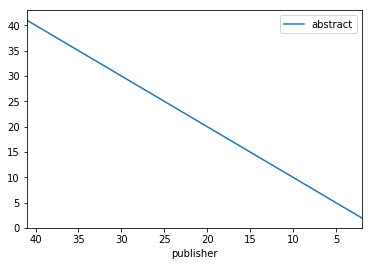

In [45]:
df.groupby(by=["publisher"])['publisher','abstract'].count().sort_values(by=['abstract'], ascending=False).head(20).plot(x='publisher',y='abstract')

In [46]:
def splitList(thelist):
    keys = defaultdict(int);
    for k in thelist:
        if  not isinstance(k,float):
            for kk in set(k.replace(',',';').split(";")):
                kk = kk.upper();
                kk = re.sub(r"\b(\w+)(E?S)\b",r" \1",kk);
                kk = re.sub(r"\s{2,}"," ",kk).strip()
                keys[kk]+=1;
    return keys;

In [48]:
keywords = splitList(df.author_keywords.tolist());
pd.DataFrame({
    "keys": list(keywords.keys()),
    "counter":list(keywords.values())
}).groupby(by='keys').sum().reset_index().sort_values(by=['counter'], ascending=False).head(20)

,keys,counter
51,AUTHORSHIP ATTRIBUTION,50
40,AUTHOR IDENTIFICATION,23
444,STYLOMETRY,22
279,MACHINE LEARNING,18
468,TEXT MINING,10
58,AUTHORSHIP VERIFICATION,9
56,AUTHORSHIP IDENTIFICATION,9
464,TEXT CLASSIFICATION,8
138,DATA MINING,7
48,AUTHORSHIP,6


In [49]:
keywords = splitList(df.keywords.tolist());
pd.DataFrame({
    "keys": list(keywords.keys()),
    "counter":list(keywords.values())
}).groupby(by='keys').sum().reset_index().sort_values(by=['counter'], ascending=False).head(20)

,keys,counter
65,AUTHORSHIP ATTRIBUTION,77
58,AUTHOR IDENTIFICATION,54
40,ARTIFICIAL INTELLIGENCE,44
584,LEARNING SYSTEM,41
193,COMPUTATIONAL LINGUISTIC,40
138,CLASSIFICATION (OF INFORMATION),34
595,LINGUISTIC,28
687,NATURAL LANGUAGE PROCESSING SYSTEM,27
68,AUTHORSHIP IDENTIFICATION,26
71,AUTHORSHIP VERIFICATION,26


In [50]:
d = df.keywords +";"+ df.author_keywords
keywords = splitList(d.tolist());
cloud = pd.DataFrame({
    "keys": list(keywords.keys()),
    "counter":list(keywords.values())
}).groupby(by='keys').sum().reset_index().sort_values(by=['counter'], ascending=False);

cloud.head(20)

,keys,counter
66,AUTHORSHIP ATTRIBUTION,87
56,AUTHOR IDENTIFICATION,47
524,LEARNING SYSTEM,36
35,ARTIFICIAL INTELLIGENCE,32
187,COMPUTATIONAL LINGUISTIC,30
246,DATA MINING,28
71,AUTHORSHIP IDENTIFICATION,28
74,AUTHORSHIP VERIFICATION,24
139,CLASSIFICATION (OF INFORMATION),23
621,NATURAL LANGUAGE PROCESSING SYSTEM,23


In [51]:
plt.figure(figsize=(15,30))
wc = wordcloud.WordCloud(background_color='white', random_state=0)
wc.generate_from_frequencies(cloud.as_matrix())
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'items'

In [ ]:
keywords

In [ ]:
def cleanAuthor(x):
    x = re.sub(r'\w\.', '',x)
    return re.sub(r"\s*and\s*",';',x);
    
author = df.author.apply(lambda x: cleanAuthor(x));
author = splitList(author.tolist())
author = zip(author.keys(), author.values())

plt.figure(figsize=(15,30))
wc = wordcloud.WordCloud(background_color='white', random_state=0, width=800, height=400)
wc.generate_from_frequencies(author)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
df.author

In [ ]:
df.to_csv(os.path.join(home,r"Downloads/scopus.csv"), index=False, encoding='utf-8')

# text analysis

In [52]:
df2 = df[['abstract','year']].copy();
df2.dropna(inplace=True);
abstracts = df2.abstract.tolist();
year = df2.year.tolist();

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer;
from sklearn.model_selection import train_test_split;
from sklearn.linear_model import LogisticRegression;
from sklearn.metrics import roc_auc_score;
from sklearn.preprocessing import LabelBinarizer;
from sklearn.decomposition import PCA;

In [54]:
xtrain, xtest, ytrain, ytest = train_test_split(abstracts, year, random_state=0)

In [55]:
vect = TfidfVectorizer(analyzer='char',lowercase=False, min_df=0.01, max_df=0.80, ngram_range=(3,5))

In [56]:
mxtrain = vect.fit_transform(xtrain);
mxtest = vect.transform(xtest);

In [57]:
len(vect.vocabulary_)

31746

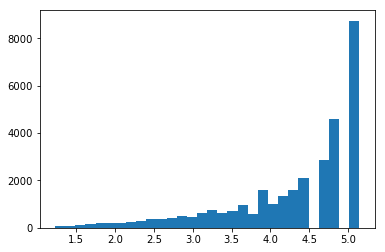

In [58]:
plt.hist(vect.idf_, bins=30);

In [59]:
clf = LogisticRegression(random_state=0, C=0.1)
pca = PCA(1000,random_state=0);
mxtrain = pca.fit_transform(mxtrain.todense())
clf.fit(mxtrain,ytrain);
probtrain = clf.predict_proba(mxtrain)
probtest  = clf.predict_proba(pca.transform(mxtest.todense()))

In [60]:
rocs = [
    {
        'classe':c,
        'roc_train':roc_auc_score(y_true=np.array(ytrain)==c, y_score=probtrain[:,i]),
        'roc_test':roc_auc_score(y_true=np.array(ytest)==c, y_score=probtest[:,i])
    }
    
    for i,c in enumerate(clf.classes_)]

pd.DataFrame(rocs)

,classe,roc_test,roc_train
0,2015,0.601996,0.999641
1,2016,0.574830,1.000000
2,2017,0.709330,0.998818
3,2018,0.887097,1.000000


In [ ]:
plt.plot(pca.explained_variance_.cumsum())

In [66]:
def buildVocab(x):
    voc = set();
    for v in x:
        voc = set(voc.union(set(v)));
    voc = sorted(list(voc));
    voc = {c:i for i,c in enumerate(voc) };
    return voc ;

vocabularyIndex = buildVocab(xtrain)

In [69]:
def ngramToVector(ngram):
    vector = np.zeros(len(vocabularyIndex));
    for c in ngram:
        vector[vocabularyIndex[c]] +=1;
    return vector;

In [71]:
ngramToVector("abc")

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])